In this notebook We try to define an calculate a useful target for modeling. We aim to engineer a feature like 'Joule per kg per km'

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # plotting library
import pandas as pd
import folium

df=pd.read_parquet('/home/joelva/code/pgt-group-3/data/raw/Complete_Set/HECTORdataAggregated_20240318144231.parquet')

In [3]:
# Make a datetime column and drop the old one

# Drop the 'datetime' column
df = df.drop(columns=['datetime'])

# Rename 'Vdatetime' column to 'datetime'
df = df.rename(columns={'Vdatetime': 'datetime'})

# making a datetime column
df['datetime'] = pd.to_datetime(df['datetime'])

In [4]:
%run -i './Utilities.ipynb'

First we do some plots to get a visual of some of the data and features we will use

In [5]:
# define a function that plots the data of a given column for a single given day

def plot_single_day(df, column, day):
    """
    Plot data for a single day from a pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - column (str): Name of the column to plot.
    - day (str): Date in the format 'YYYY-MM-DD' to plot data for.
    """
    
    # Filter data for the specific day
    mask = (df['datetime'].dt.date == pd.to_datetime(day).date())
    day_data = df.loc[mask]

    # Check if there is data to plot
    if day_data.empty:
        print(f"No data available for {day}")
        return

    # Plotting
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.plot(day_data['datetime'], day_data[column], marker='o', linestyle='-')
    plt.title(f"{column} on {day}")  # Set the title of the plot
    plt.xlabel('Time')  # Label for the x-axis
    plt.ylabel(column)  # Label for the y-axis
    plt.grid(True)  # Enable grid for easier readability
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()  # Display the plot


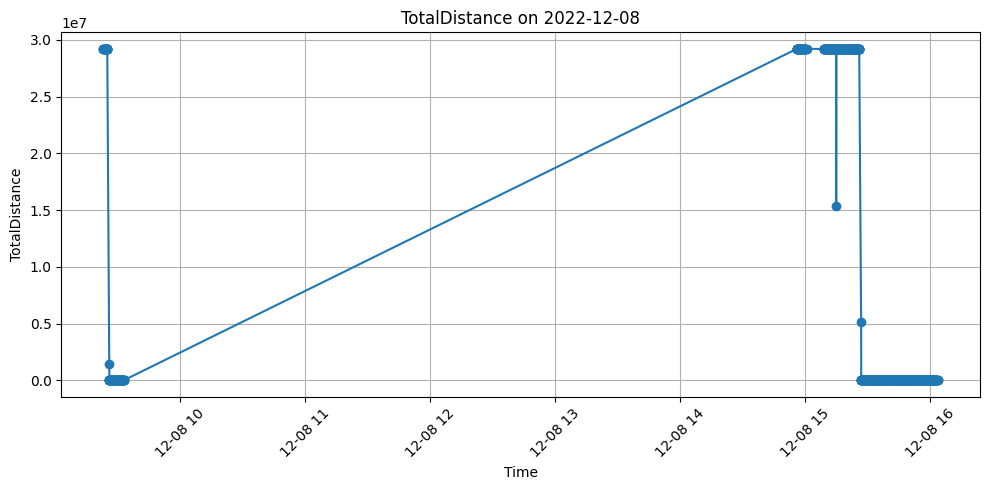

In [6]:
plot_single_day(df, 'TotalDistance', '2022-12-08')

In [7]:
# Drop rows where any of these critical columns are missing and/or GPS data are 0
df_clean = df.dropna(subset=['datetime', 'GPSLatitude', 'GPSLongitude'])

df_clean = df_clean[(df_clean['GPSLatitude'] > 0) | (df_clean['GPSLongitude'] > 0)]

df = df_clean

Here we append a column to the DataFrame that contains the distance between two consecutive GPS coordinates. This is done by using the haversine formula, which calculates the great-circle distance between two points on a sphere given their longitudes and latitudes.

In [8]:
# Defining the Harversine formula

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    return c * r

# Here we define the function that appends a colun with the distance called 'distance_km' to the DataFrame.
# This function resets the distance at the start of each day.

def append_distance_column(df):
    """
    Appends a column 'distance_km' to the DataFrame which contains the distance
    traveled between consecutive GPS readings in kilometers, resetting to zero
    at the start of each day.
    """
    # Ensure the data is sorted chronologically
    df.sort_values('datetime', inplace=True)

    # Convert 'datetime' to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Shift the latitude, longitude, and date to get the "previous" coordinates and date
    df['prev_latitude'] = df['GPSLatitude'].shift(1)
    df['prev_longitude'] = df['GPSLongitude'].shift(1)
    df['prev_date'] = df['datetime'].dt.date.shift(1)

    # Calculate the distance using the haversine function and reset distance at the start of each day
    df['distance_km'] = df.apply(
        lambda row: 0 if row['datetime'].date() != row['prev_date'] else
                    haversine(row['prev_longitude'], row['prev_latitude'],
                              row['GPSLongitude'], row['GPSLatitude']) if not pd.isna(row['prev_longitude']) else 0,
        axis=1
    )

    # Remove the temporary columns
    df.drop(['prev_latitude', 'prev_longitude', 'prev_date'], axis=1, inplace=True)


In [9]:
# Example of using the function with your DataFrame
append_distance_column(df)
print(df.head())  # To see the first few rows with the new 'distance_km' column

                  datetime   BatMaxV  BatMinV  BatSOC  BatTotalCurrent  \
268758 2022-08-01 04:04:05     0.000     0.00     0.0              NaN   
268764 2022-08-01 04:05:05     0.000     0.00     0.0              NaN   
268777 2022-08-01 04:08:00  4144.650  4118.45   100.0           28.650   
268778 2022-08-01 04:08:01  4141.575  4115.65   100.0           31.625   
268779 2022-08-01 04:08:02  4122.875  4096.50   100.0           63.100   

        BatTotalVoltage  CompOnOff  StopOnOff  ThrottlePerc  BrakePerc  ...  \
268758            0.000        0.0        0.0           0.0        0.0  ...   
268764            0.000        0.0        0.0           0.0        0.0  ...   
268777          652.750        0.0        1.0         276.9        0.0  ...   
268778          652.200        0.0        1.0         252.6        0.0  ...   
268779          648.925        0.0        1.0         344.9        1.8  ...   

        MotorTorque  MotorUseCurrent  MotorTemp  BattOutputPower  \
268758      

In [10]:
df['distance_km'].head(40)

268758    0.000000
268764    0.010523
268777    0.011440
268778    0.013359
268779    0.019167
268780    0.045684
268781    0.034957
268782    0.101178
268783    0.067859
268784    0.001857
268787    0.013668
268788    0.007157
268789    0.067273
268790    0.079326
268791    0.013637
268792    0.080546
268793    0.127554
268794    0.138774
268795    0.140311
268796    0.137384
268797    0.136920
268798    0.147814
268799    0.159647
268800    0.161932
268801    0.150034
268802    0.086511
268803    0.094411
268804    0.135971
268805    0.068122
268806    0.072110
268807    0.087453
268808    0.090186
268809    0.084015
268810    0.062097
268811    0.021044
268812    0.006631
268813    0.043981
268814    0.071833
268817    0.008907
268818    0.011100
Name: distance_km, dtype: float64

### LET OP: Hier de drie assen bij elkaar opgeteld. Mooier zou zijn om de TotalAxle column te gebruiken. Klopt het dat 'TotalAxle' gelijk is aan de drie assen bij elkaar?

In [11]:
df['NetWeight'] = df['FrontAxle'] + df['RearAxle1'] + df['RearAxle2'] - 17000

In [12]:
df = df[(df['NetWeight'] >= 0)]

Here we calculate an Energy Efficiency Metric (EEM), which is defined as
EEM = Total Energy Consumed (Joules) / (NetWeight (Kg) * Distance (Km))
EEM is therefor in J/kg*km

​
 



In [13]:
# Calculate MotorJoules
df['MotorJoules'] = df['MotorPowerDraw'] * 10  # Each entry is a 10-second interval

# Calculate EEM
df.replace(0, np.nan, inplace=True)  # Avoid division by zero, if applicable
df['EEM'] = df['MotorJoules'] / (df['NetWeight'] * df['distance_km'])
df['EEM'].replace([np.inf, -np.inf], np.nan, inplace=True)  # Clean up infinite values



/tmp/ipykernel_4987/501385774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MotorJoules'] = df['MotorPowerDraw'] * 10  # Each entry is a 10-second interval
/tmp/ipykernel_4987/501385774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(0, np.nan, inplace=True)  # Avoid division by zero, if applicable
/tmp/ipykernel_4987/501385774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [14]:
df.head()

,datetime,BatMaxV,BatMinV,BatSOC,BatTotalCurrent,BatTotalVoltage,CompOnOff,StopOnOff,ThrottlePerc,BrakePerc,...,BattOutputPower,MotorPowerDraw,TotalFCPower,ActualSpeed,TotalPowerDraw,AirTemp,distance_km,NetWeight,MotorJoules,EEM
268758,2022-08-01 04:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.041795,NaN,NaN,20.6,NaN,300.0,NaN,NaN
268764,2022-08-01 04:05:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.040000,NaN,NaN,20.6,0.010523,300.0,NaN,NaN
268777,2022-08-01 04:08:00,4144.650,4118.45,100.0,28.650,652.750,NaN,1.0,276.9,NaN,...,18697.625,10775.9700,-0.089500,7.074375,10817.866667,20.6,0.011440,425.0,107759.700,22164.369386
268778,2022-08-01 04:08:01,4141.575,4115.65,100.0,31.625,652.200,NaN,1.0,252.6,NaN,...,20614.725,12420.8750,-0.083000,10.250625,12420.875000,20.6,0.013359,532.5,124208.750,17461.145288
268779,2022-08-01 04:08:02,4122.875,4096.50,100.0,63.100,648.925,NaN,1.0,344.9,1.8,...,40926.925,33299.9425,-0.093500,17.381875,33299.942500,20.6,0.019167,512.5,332999.425,33899.019598


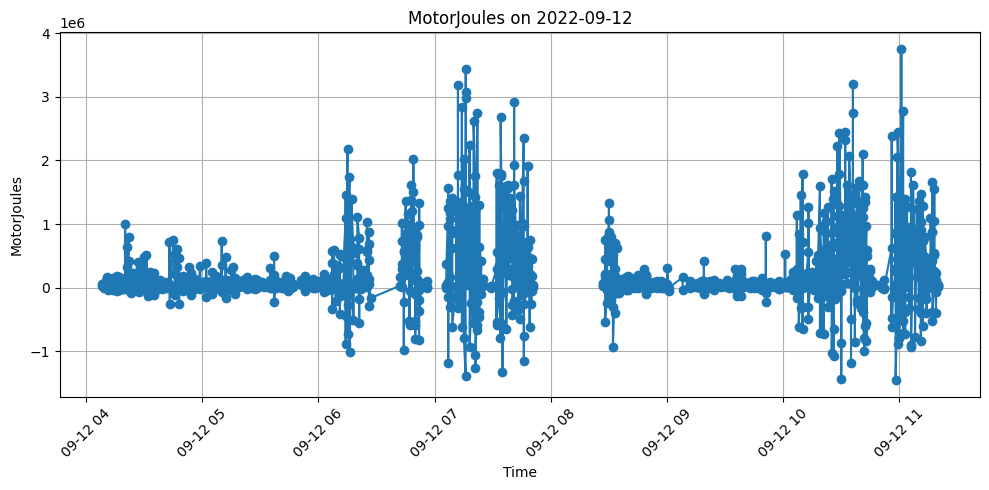

In [15]:
plot_single_day(df, 'MotorJoules', '2022-09-12')